In [1]:
## Computes and plots FFTs of all .csv files in this directory
#IGNORES SURFACE RETURN ~first 20 px of data

###TODO: ADD MORE DATA
#TODO: change x axis to depth in m assuming a dielectric of water ice

In [14]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import pandas as pd
import glob #allegedly this helps access files
from fft_radarfuncs import *
from lmfit.models import SkewedGaussianModel


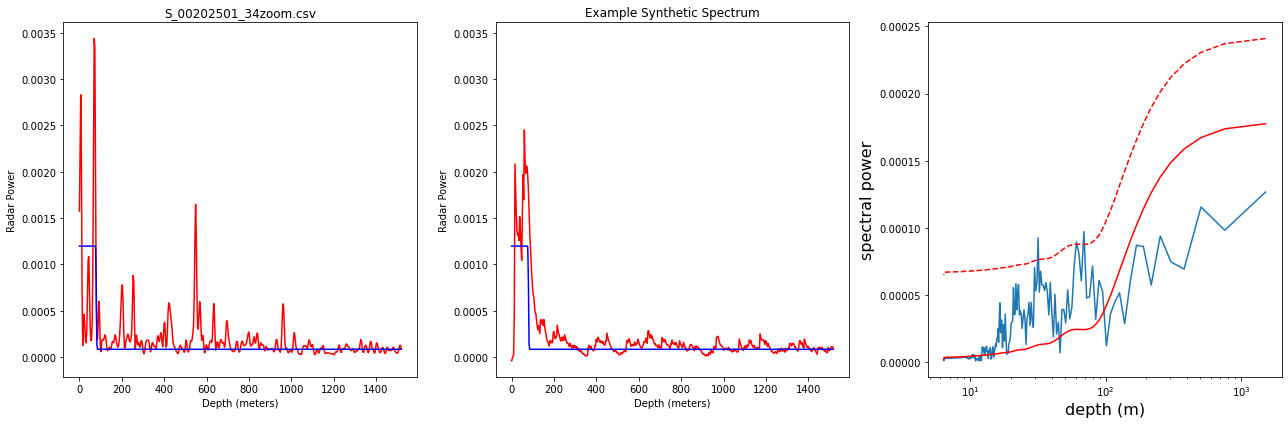

69.0049240923554 9.72745065833761e-05
60.72433320127275 8.9519065478086e-05
31.62725687566289 9.27872021888687e-05


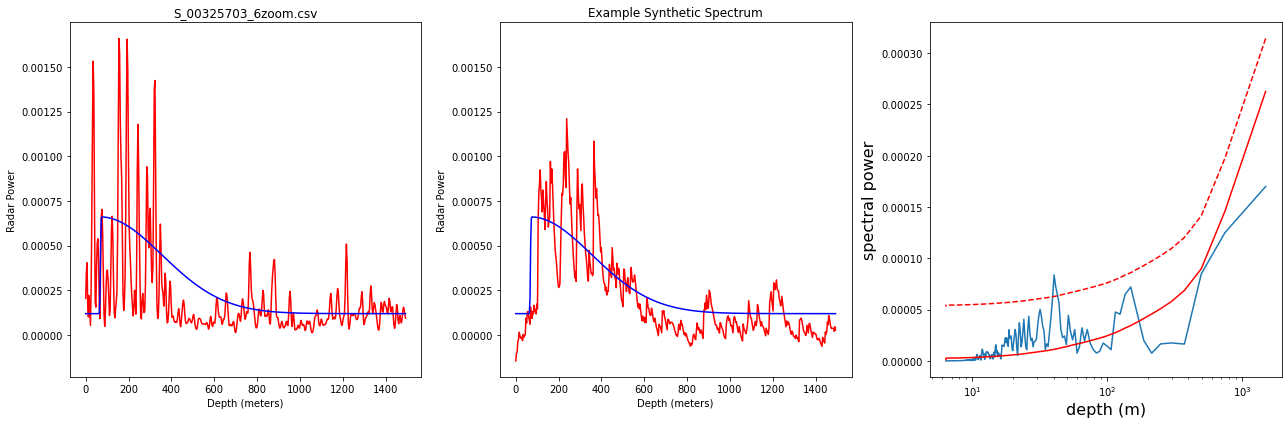

42.65010578258196 6.50832937130831e-05
41.465380621954694 7.238715171037513e-05
40.344694659199156 8.383148818975638e-05


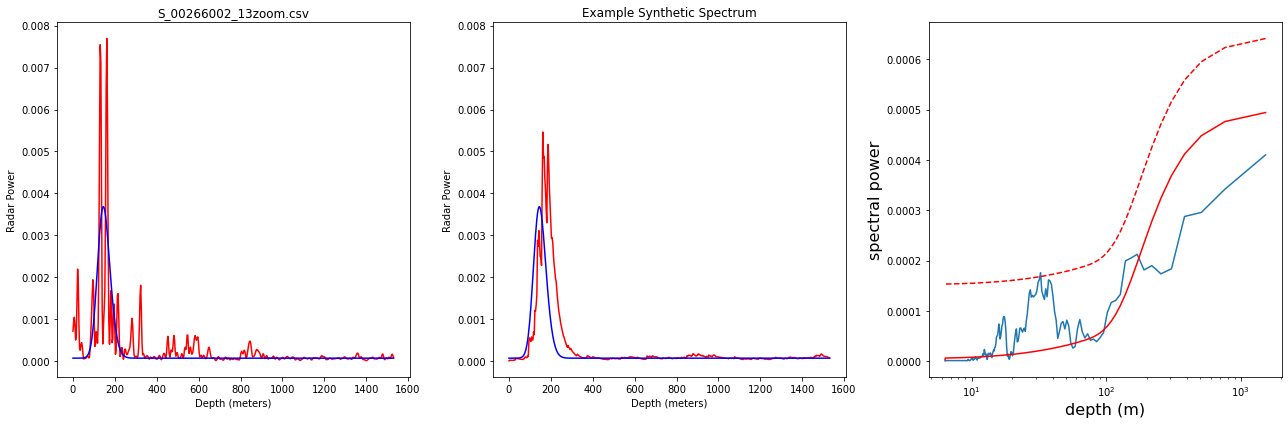

32.56990731601157 0.0001758664214440287


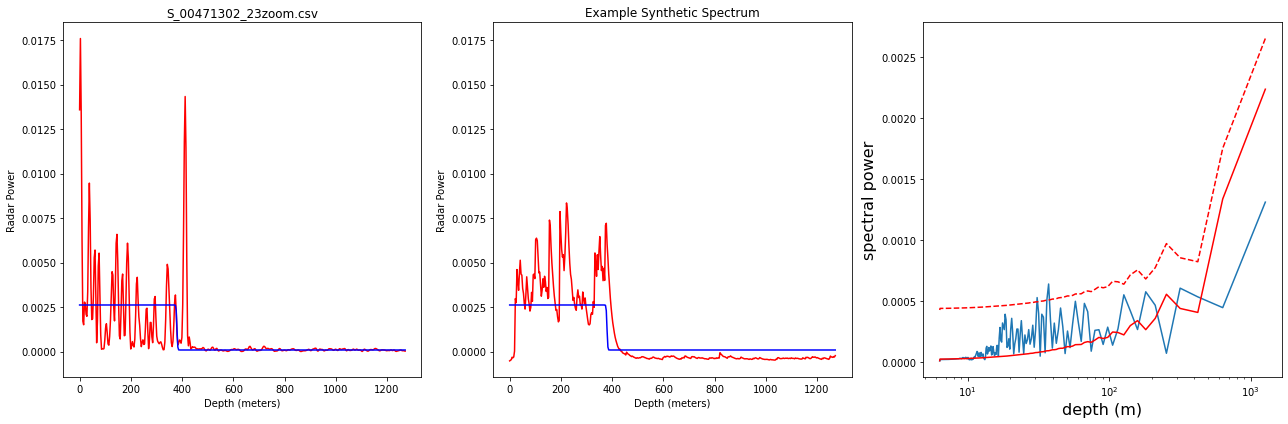

37.37943266257886 0.0006403106384701011
30.997578305553198 0.0005292070060364721


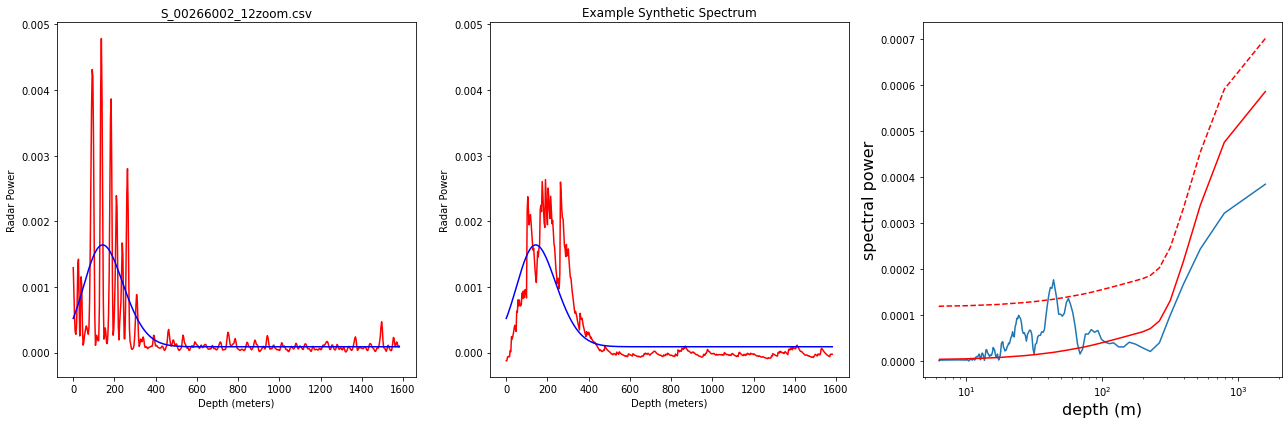

45.18556854672697 0.00015498722651300612
43.930413864873444 0.00017712283831661818
42.743105382039026 0.0001586286766878445
41.61828681935379 0.0001604714774046001
40.55115125988318 0.00014421586739611593


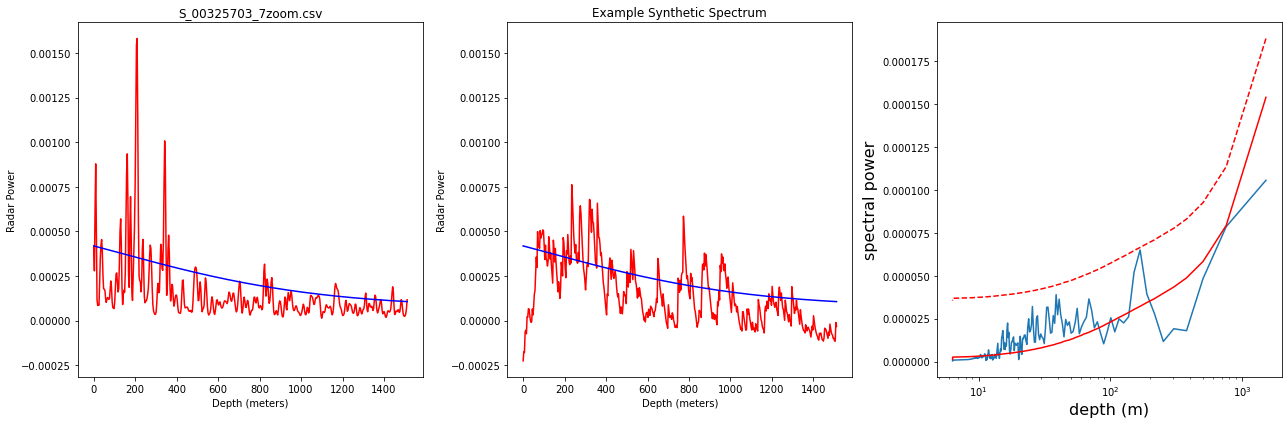

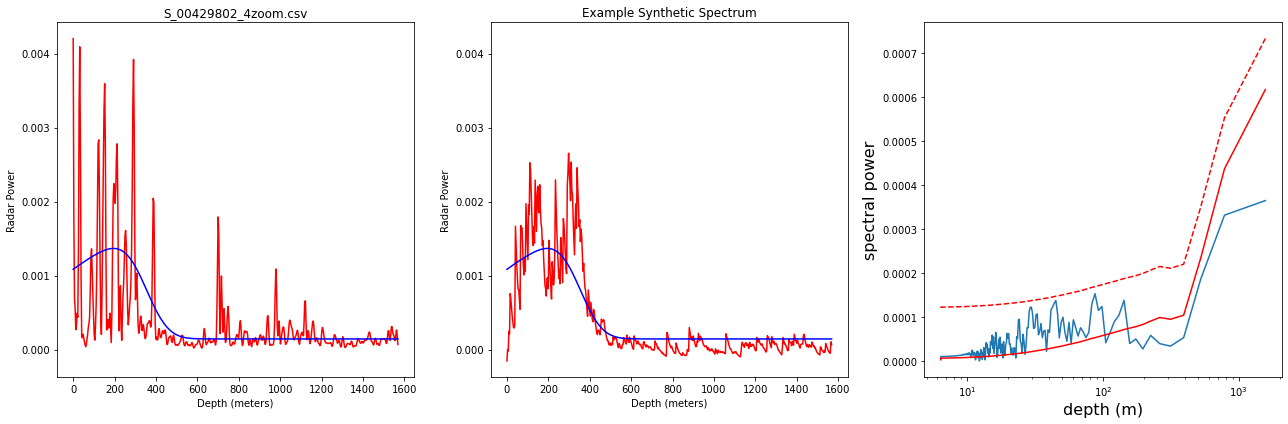

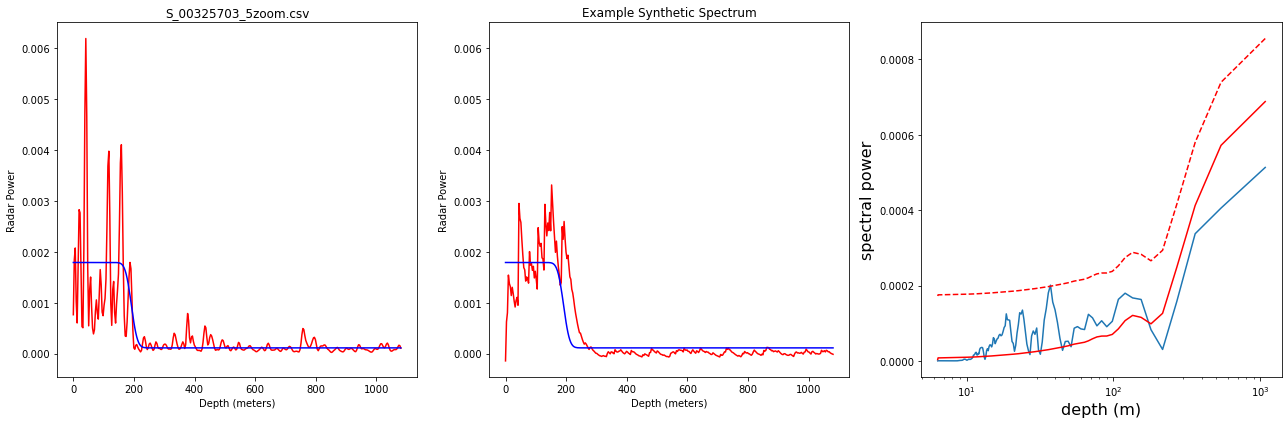

37.26693114540712 0.00020104951768259234


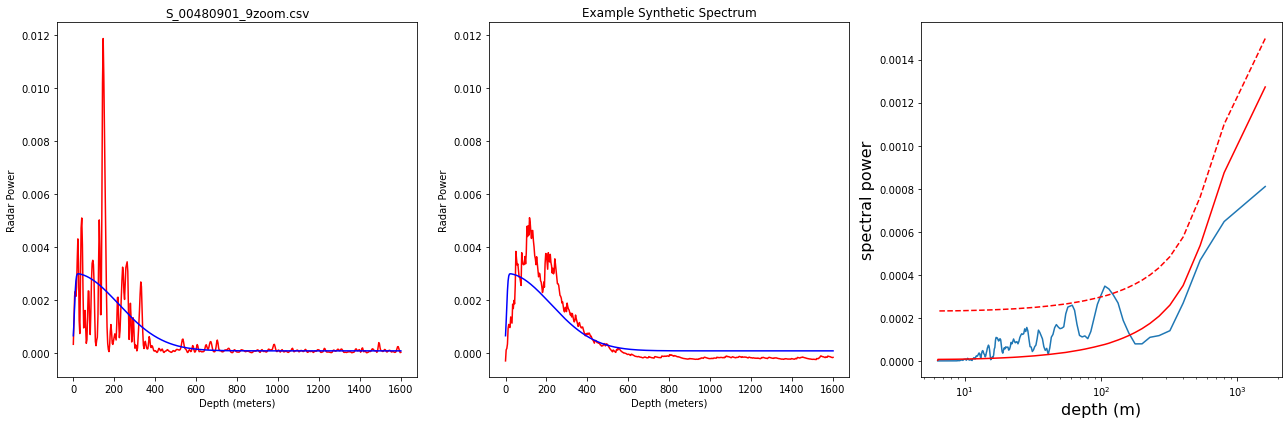

114.32220499046653 0.00033429496061285137
106.70072465776876 0.00034746365626880834
100.0319293666582 0.0003053271858333594


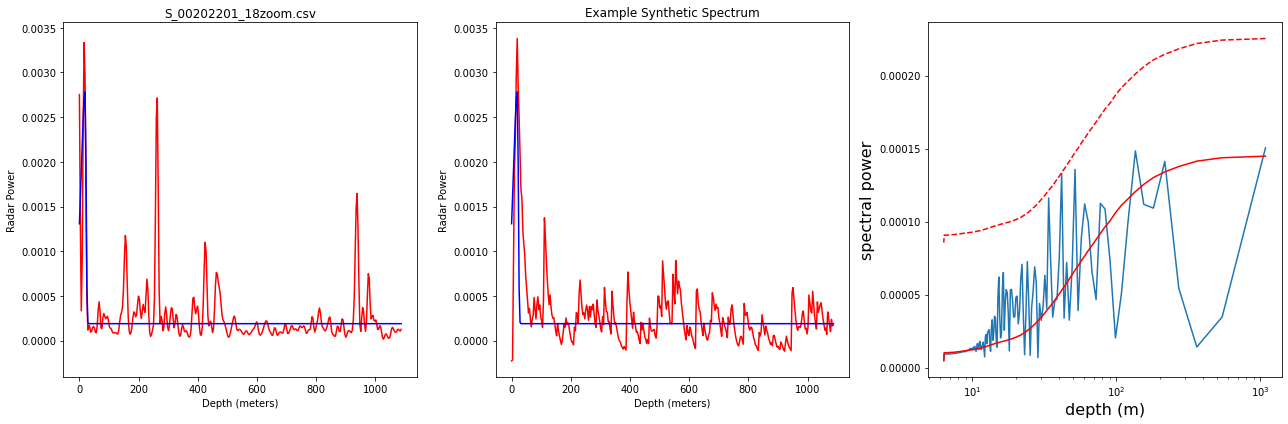

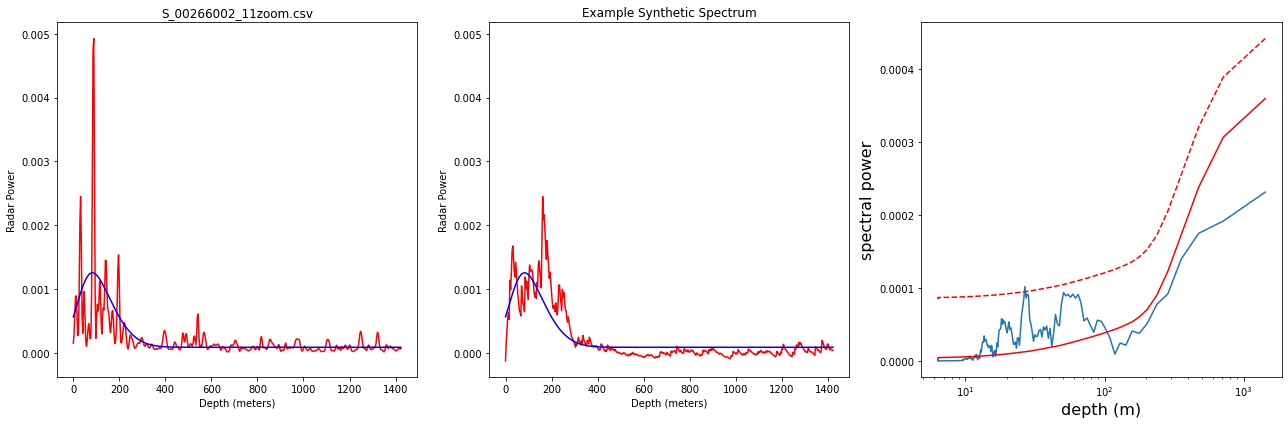

26.84959389389398 0.00010201593504713677


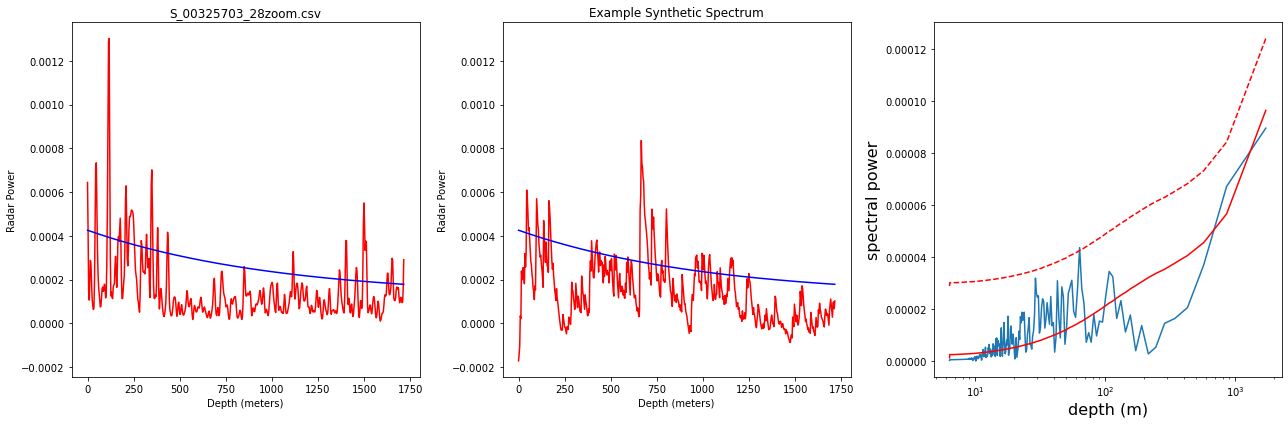

63.50395163900209 4.360771626784759e-05


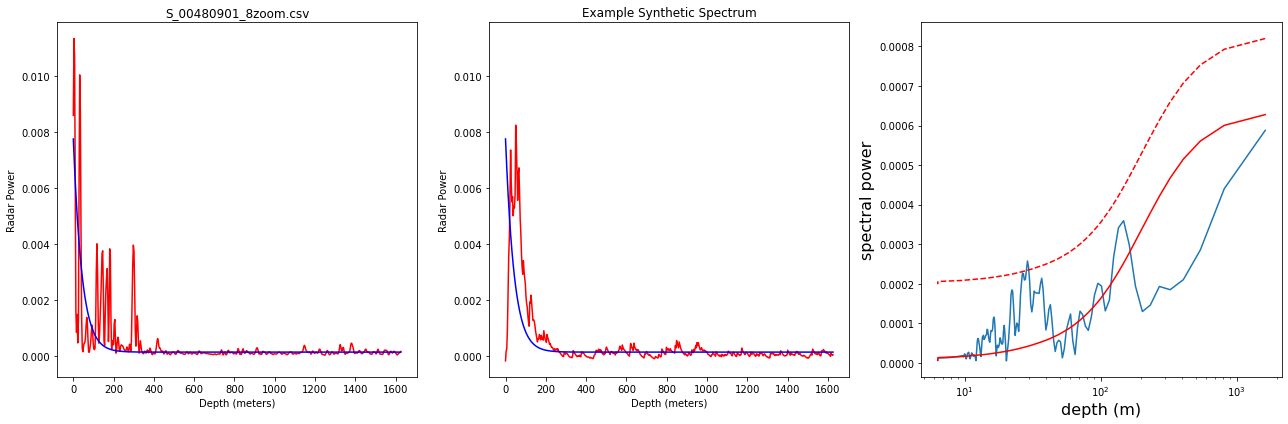

29.56119086378148 0.00024280897769703893
29.033312455499665 0.00025747364933855
28.523956096631252 0.00023355203066692366


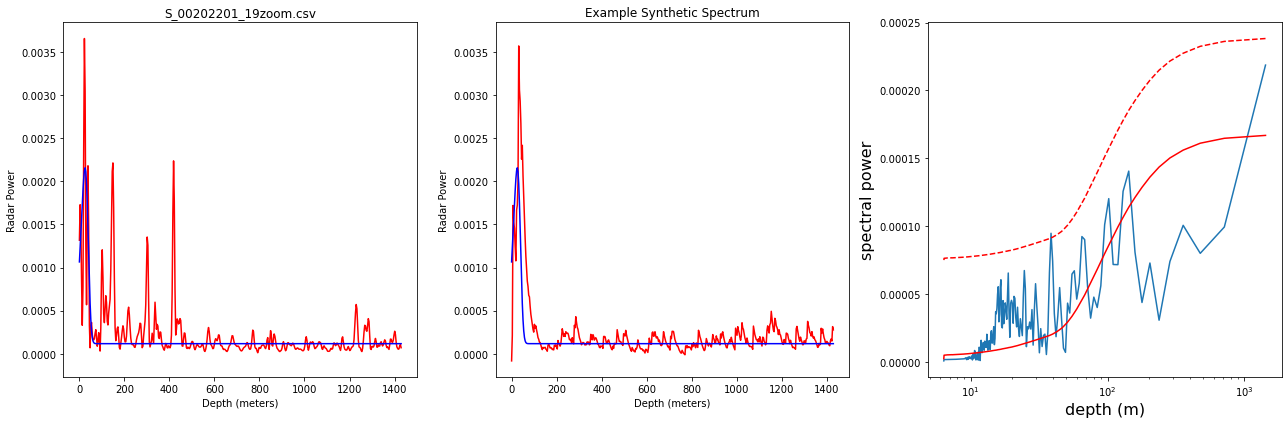

38.63154414288496 9.489334417646366e-05


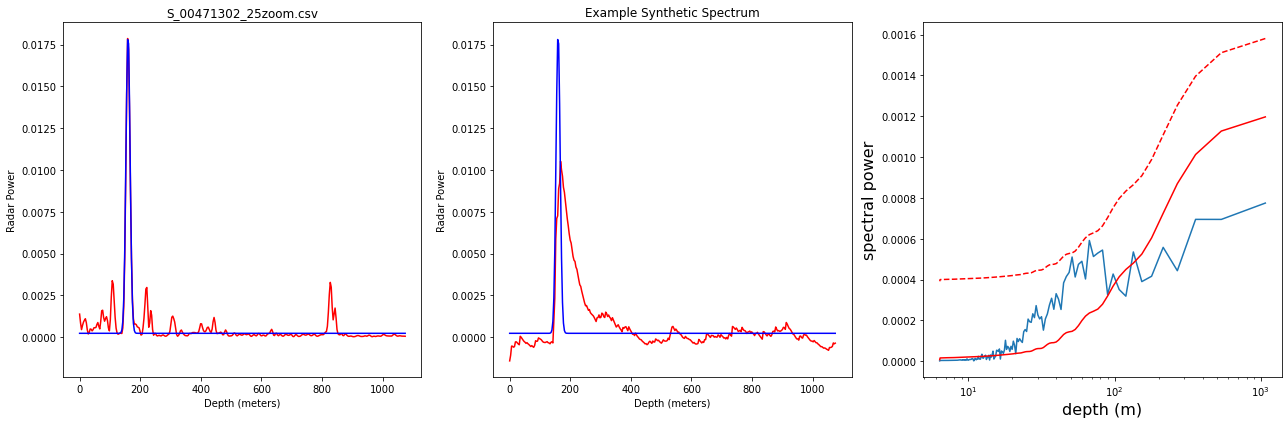

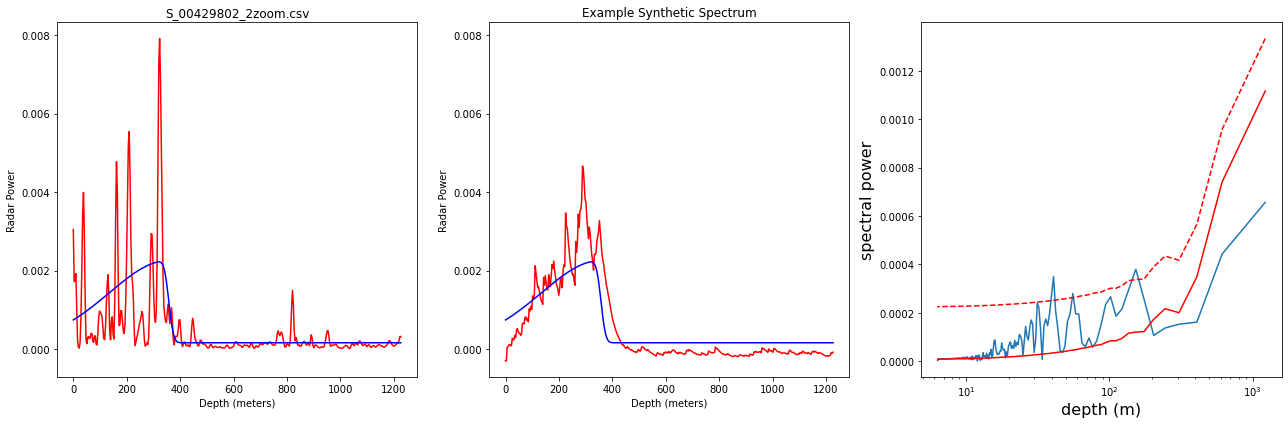

153.31626401939297 0.00037965780691560783
55.751368734324714 0.0002798522961244042
40.884337071838125 0.0003492234974381448
39.565487488875604 0.000269994319382597


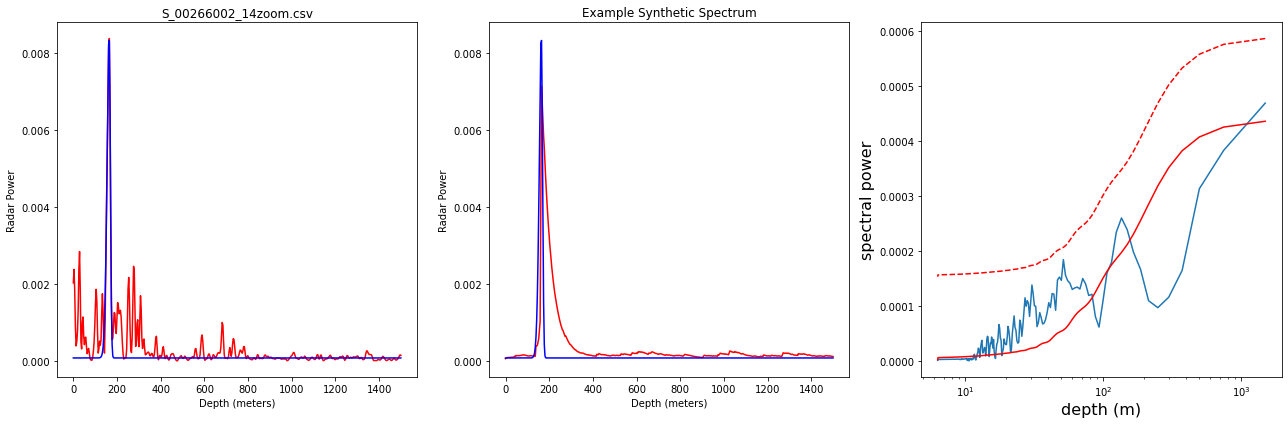

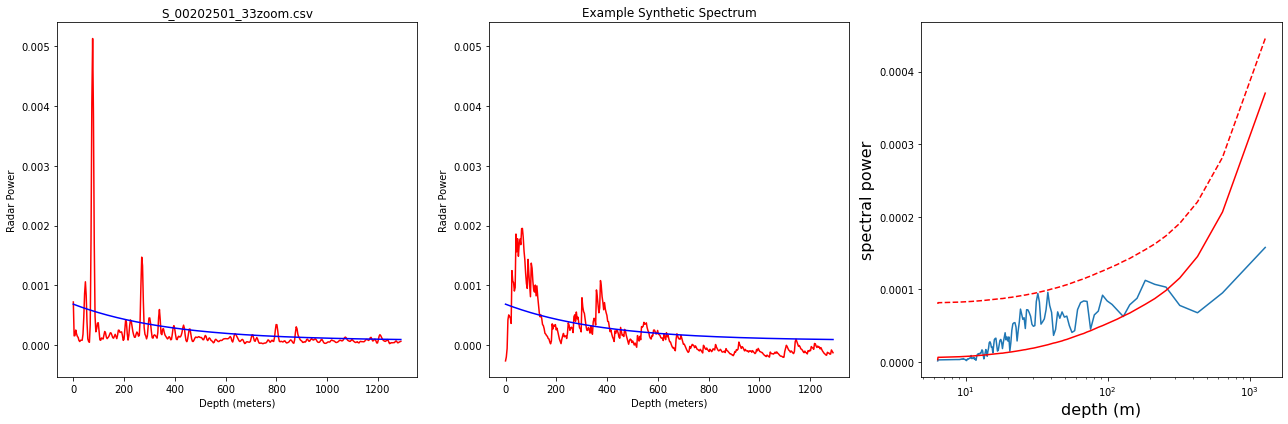

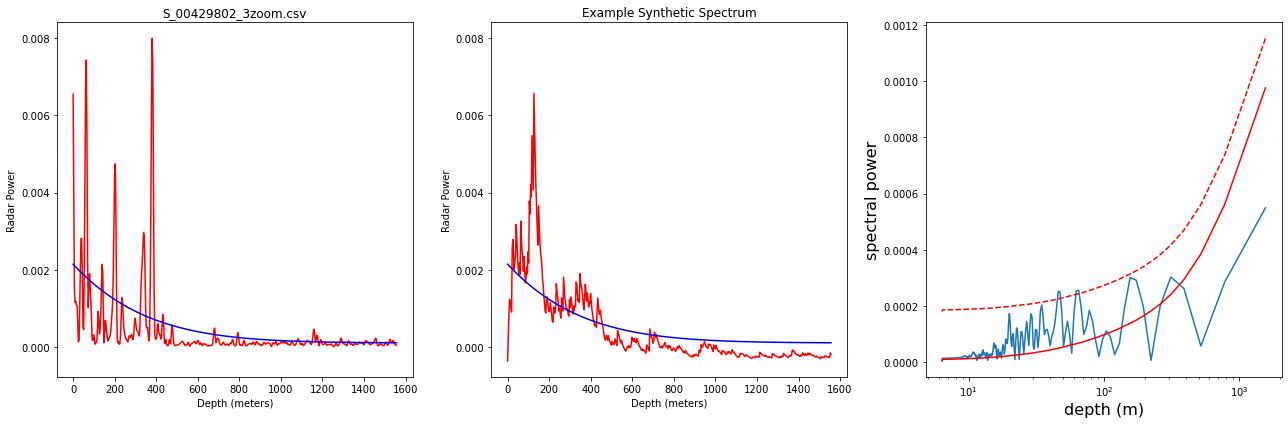

64.83917797891641 0.0002568940097539215
62.24561085975976 0.0002539585717224398
47.1557658028483 0.0002504481045344289
45.76883151452923 0.000252434697070408


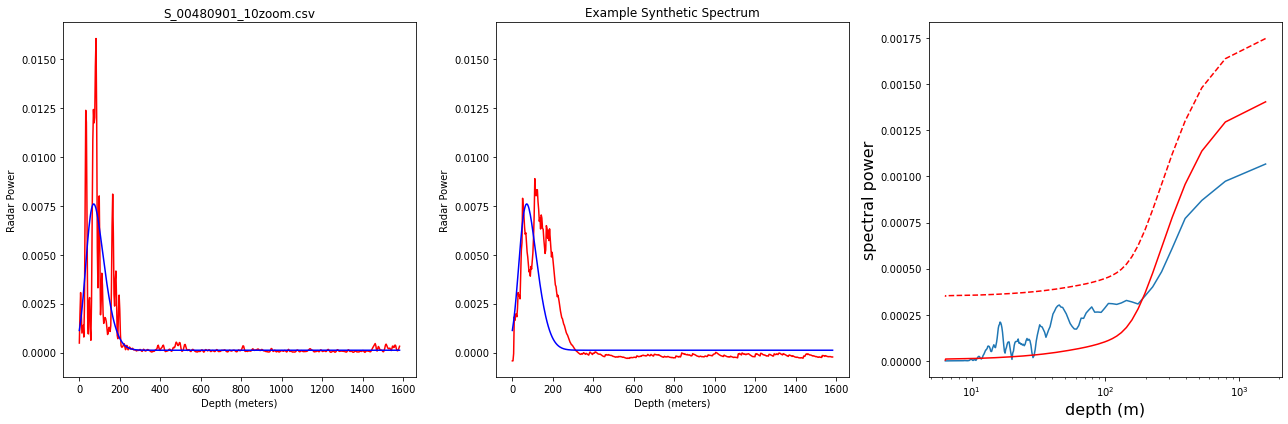

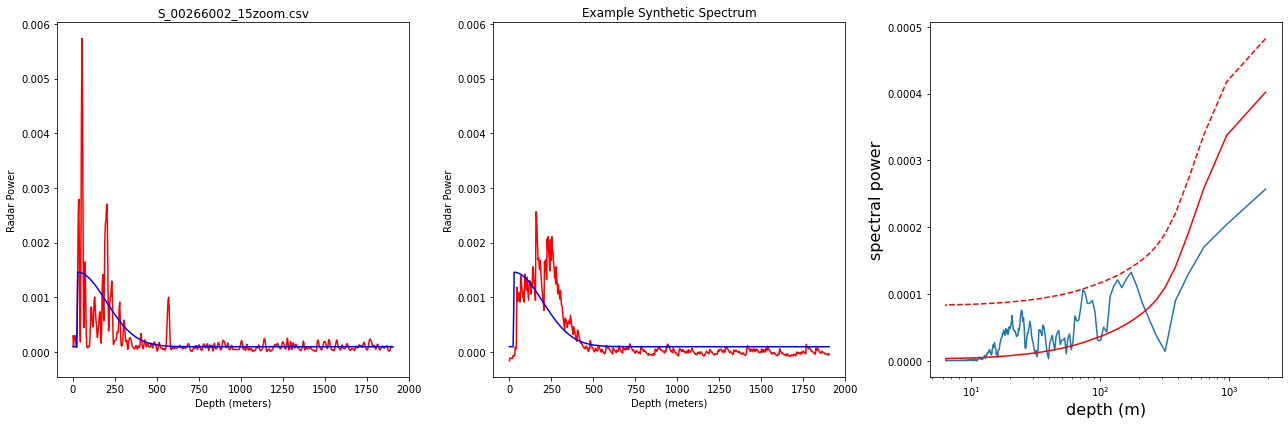

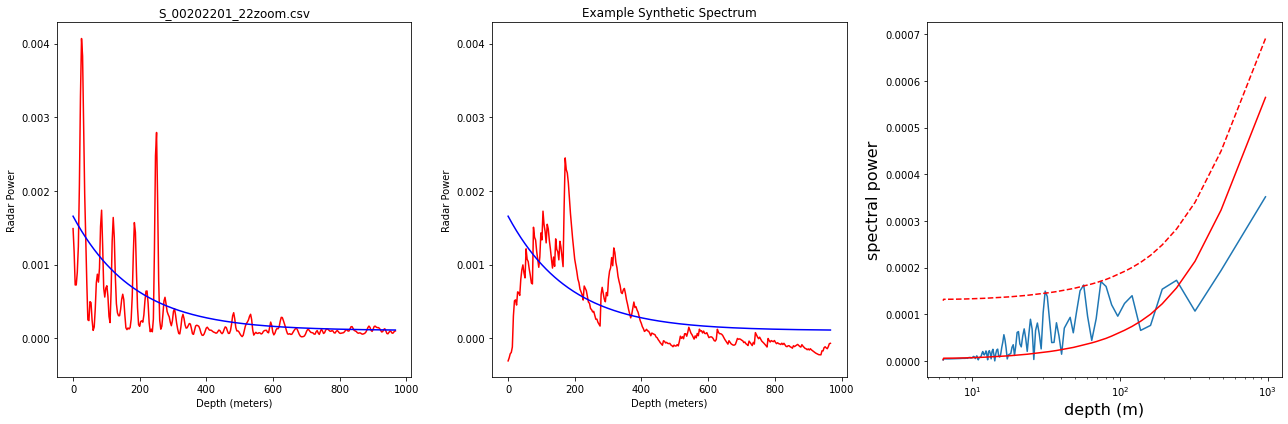

56.86148110766361 0.00016278632051561036
31.182102542912293 0.000149613989976702


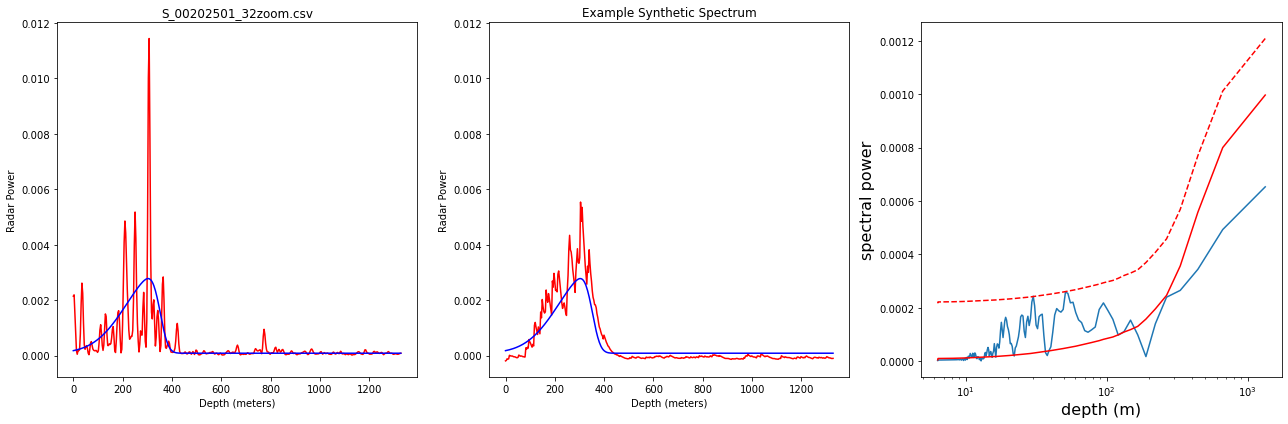

30.18065051638509 0.0002432012012881779


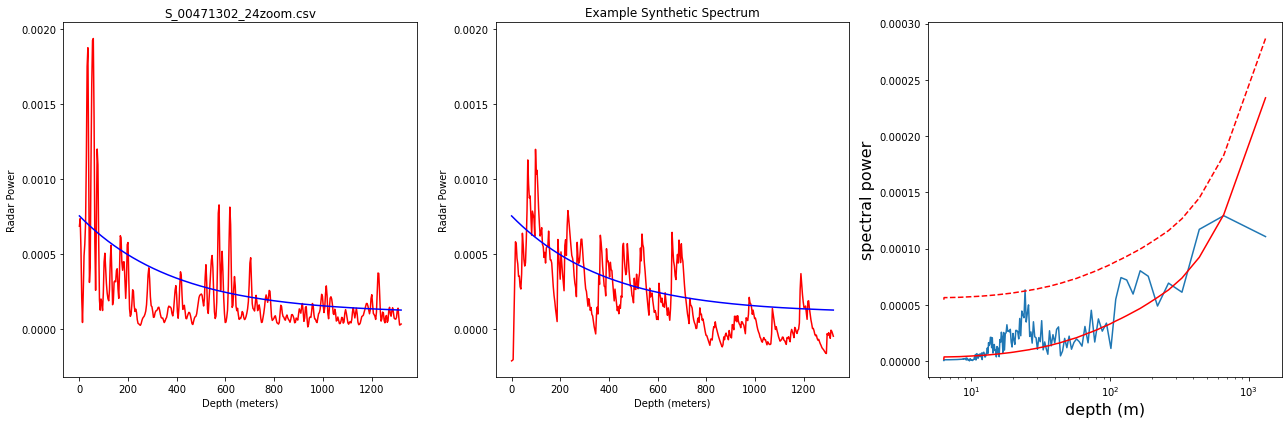

24.474258626121873 6.346713883272005e-05


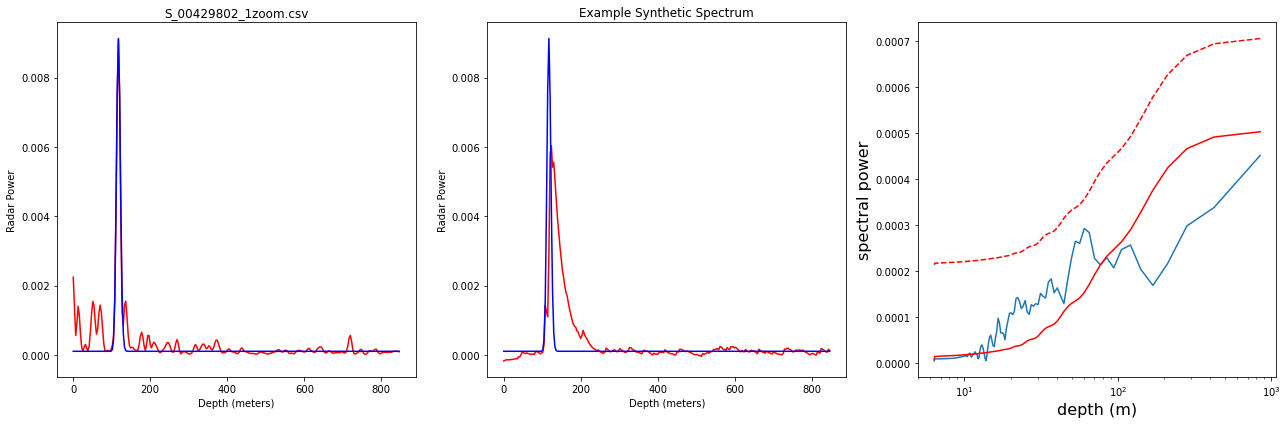

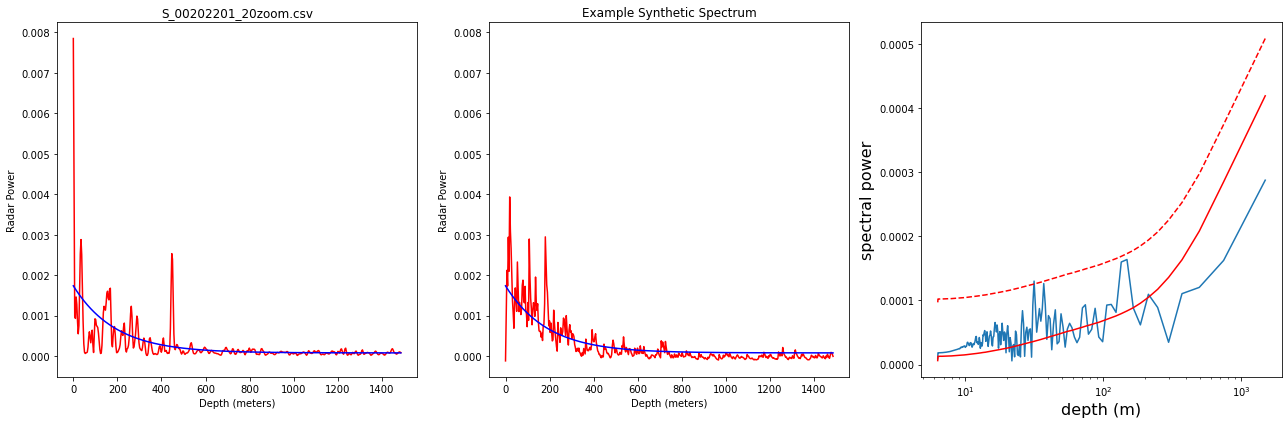

31.6258520314895 0.00013003891943174015


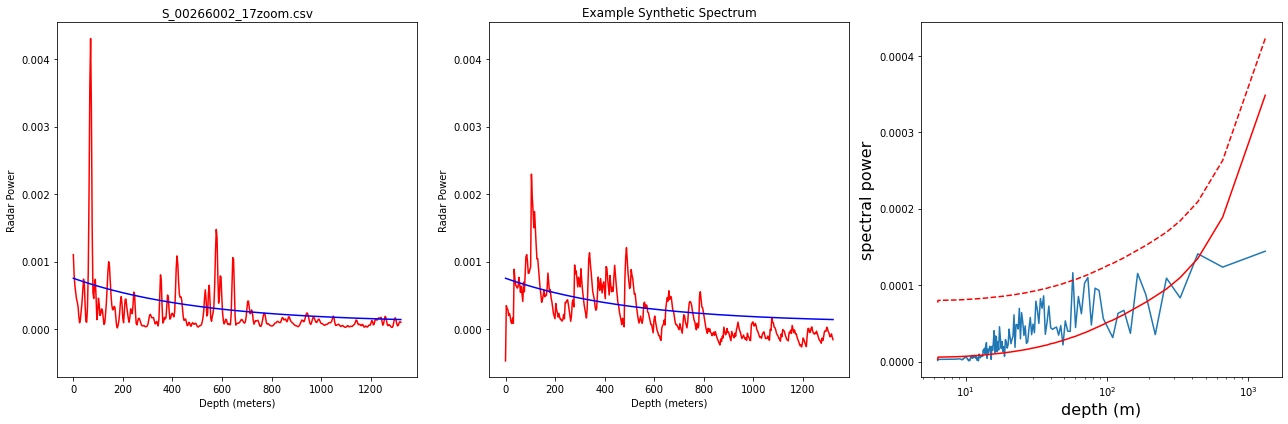

57.461302861329614 0.00011628111898118374


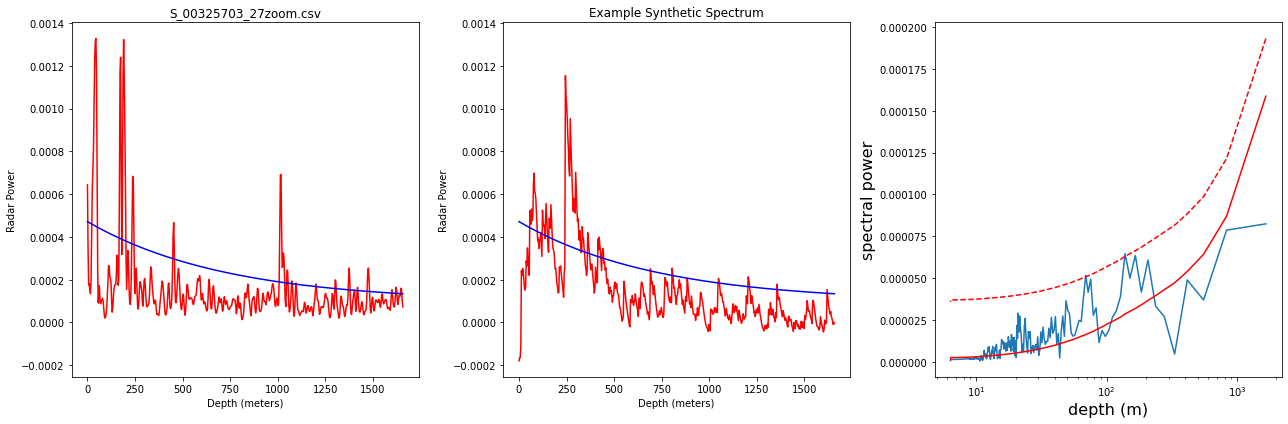

138.1298985049828 6.462040281337528e-05
69.0649492524914 5.167966523657239e-05


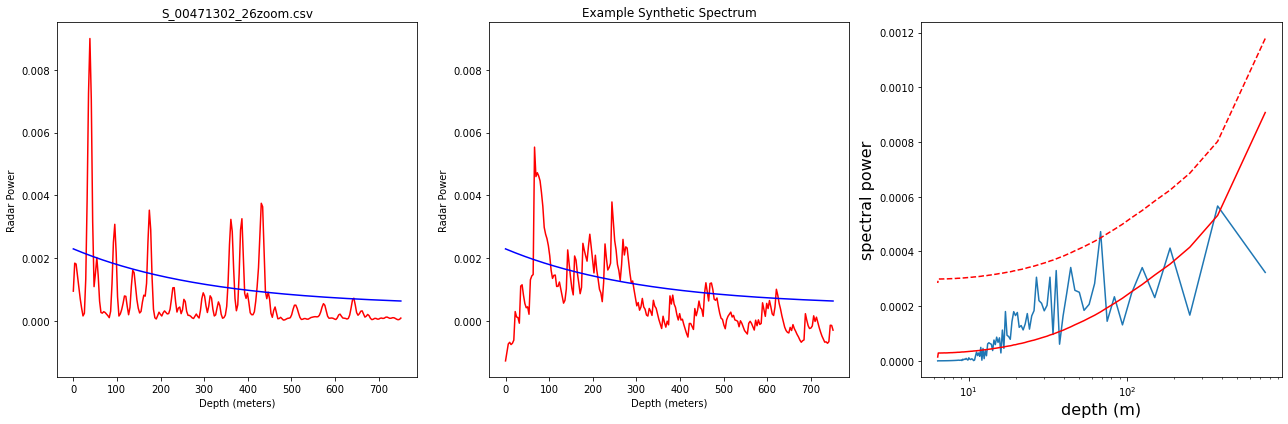

68.2846221707233 0.00047261814293555636


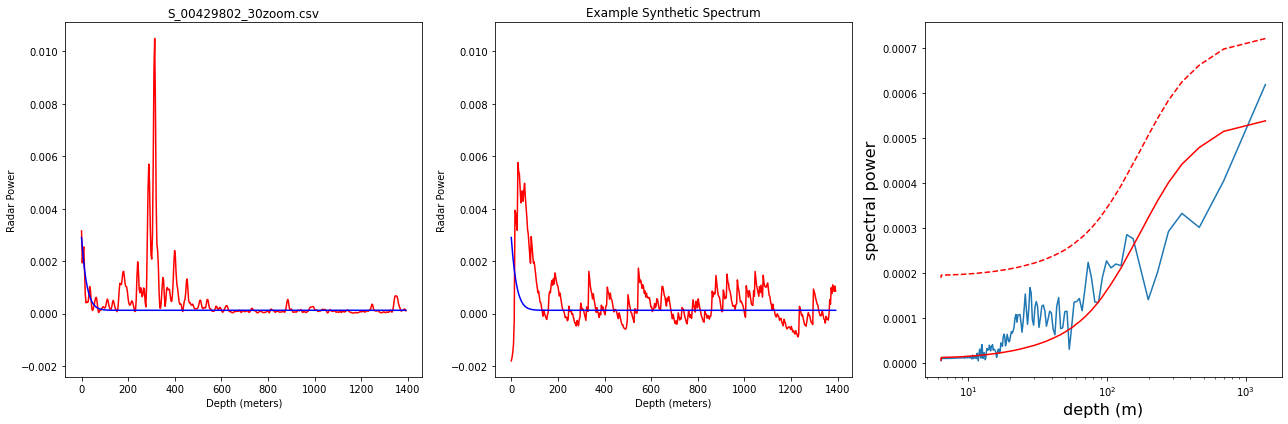

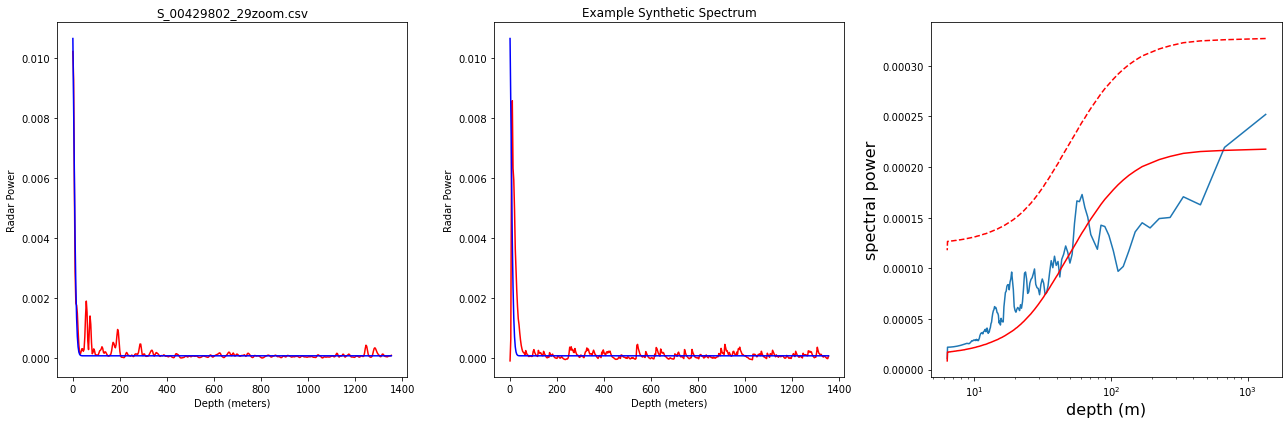

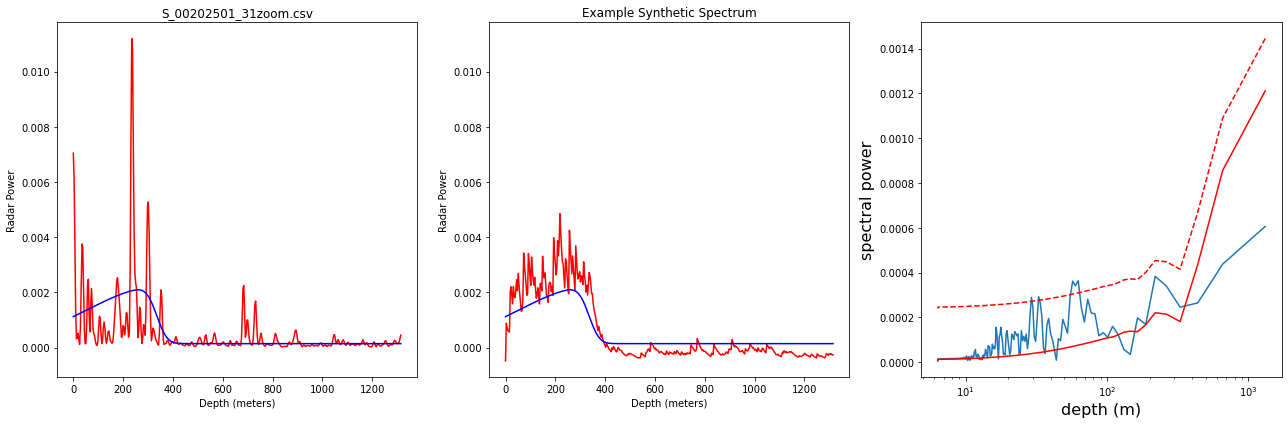

62.631967090486604 0.0003640600460460752
59.78505949546448 0.000341250526485439
57.1857090826182 0.0003621862475084591
32.88178272250547 0.0002925884664861322
29.228251308893753 0.00028945381914341825


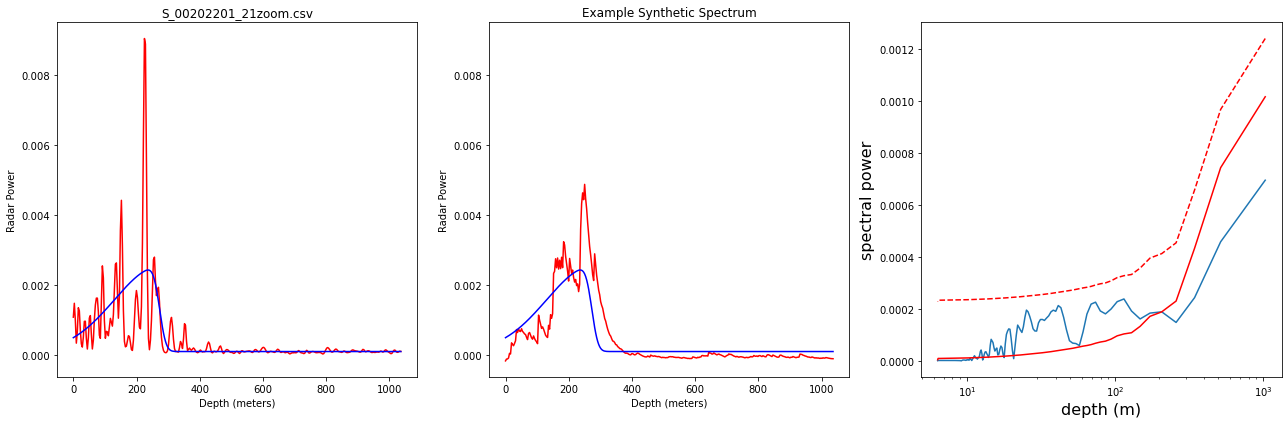

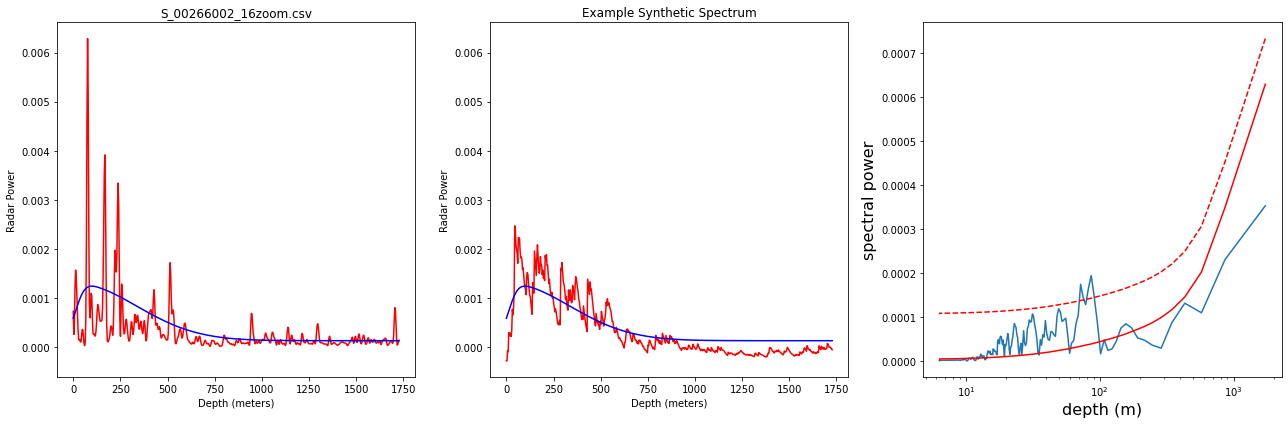

90.90968463546218 0.00014644488878168963
86.36420040368907 0.00019425922992029527
82.25161943208484 0.00016507776153189046
75.09930469886005 0.0001454403587426457
71.97016700307422 0.0001744247235772274
Number of datasets: 34


In [17]:
#Import csv files
csv_import = glob.glob("*zoom.csv")

column_names = ['depth', 'value']
csv_list = []

#compute ffts, add red noise lines to each fft plot
for i in csv_import:
    csv = pd.read_csv(i, names=column_names, skiprows=2) #skips headers
    csv_list.append(csv)
    
    x = csv.depth.to_list()
    y = csv.value.to_list()
    
    peak = y.index(max(y[0:50])) #finds surface return
    surf = x[peak] #location of surface return
    
    x = x[peak+5:]
    y = y[peak+5:]
    
    if len(x) % 2 != 0:
        x.pop()
        y.pop()
        
    x = np.array(x)
    x = x.astype(np.float)
    
    #convert pixels to meters
    c = 300000000
    pix_t = .0000000375
    er = 0.56343616981 # 1/sqrt(3.15) (dielectric = 3.15 for water ice)
    depthh = c*pix_t*er*len(x)*.5 
    x_m = (x-x[0])*c*pix_t*er*.5
    x = x_m
    
    ##compute line to fit synthetic data to
    # Skewed Gaussian fit
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1.5)
    result = model.fit(y, params, x=x)
    fit = result.best_fit +np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side

    #run fft 
    w, P1 = fft_radar(x,y)
    
    #Compute monte carlo red noise
    ft = [] #holds fourier transforms for each of 20000 random synthetic records
    syn = []

    for a in range(20000):
        r=ar1(x,y,fit) #this creates a random synthetic record with similar properties
        syn.append(r)
        w2, p = fft_radar(x,r)
        ft.append(p)
    
    
    #plot depth plot
    plt.figure(figsize = (18, 6))
    plt1 = plt.subplot(131)
    plt1.plot(x, y, 'r')
    plt1.plot(x, fit, color = 'b')
    plt1.set_title(i)
    plt1.set_ylabel('Radar Power')
    plt1.set_xlabel('Depth (meters)')

    #plot example synthetic spectra
    plt2 = plt.subplot(132, sharey=plt1)
    plt2.plot(x, syn[0], 'r')
    plt2.plot(x, fit, color = 'b')
    plt2.set_title('Example Synthetic Spectrum')
    plt2.set_ylabel('Radar Power')
    plt2.set_xlabel('Depth (meters)')
    
#     print(np.mean(y))
#     print(np.mean(syn[0]))
#     print(np.var(y))
#     print(np.var(syn[0]))
    
    #plot spectrum
    plt3 = plt.subplot(133)
    plt3.plot(w, P1)
    plt3.plot(w,np.mean(ft, axis=0), 'r')
    plt3.plot(w,np.mean(ft, axis=0)+2*np.std(ft),'r',ls='dashed')
    plt3.set_xscale('log')
    plt3.set_xlabel('depth (m)', fontsize=16)
    plt3.set_ylabel('spectral power', fontsize=16) #units are whatever JMARS reports, I have to look into this
    plt.tight_layout()
    plt.show()
    
    sig = np.mean(ft, axis=0)+2*np.std(ft)
    
    for i in range(len(P1)):
        if P1[i] > sig[i]:
            print(w[i], P1[i])

print("Number of datasets: " +str(len(csv_list)))
